<a href="https://colab.research.google.com/github/wildoctopus/FeetAndShoeMeasurement/blob/main/FeetAndShoeMeasurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import random as rng

In [37]:
#Mount data path from drive. 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
def preprocess(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    img = cv2.GaussianBlur(img, (9, 9), 0)
    img = img/255

    return img

In [40]:
def plotImage(img):
    
    plt.imshow(img)
    #plt.title('Clustered Image')
    plt.show()

In [41]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect

    print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    #cv2_imshow(crop1)

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg


In [42]:
def overlayImage(croppedImg, pcropedImg):


    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (255, 0, 0) # (B, G, R)

    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg

    return new_image


In [43]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg


In [44]:
def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img


In [45]:
def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   


    paperbb = bRect

    for i in range(len(contours)):
      color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      cv2.drawContours(drawing, cntPoly, i, color)
      #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              #(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
    
    return drawing

In [46]:
def edgeDetection(clusteredImage):
  #gray = cv2.cvtColor(hsvImage, cv2.COLOR_BGR2GRAY)
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  return edged

In [47]:
oimg = imread('/content/drive/My Drive/data/straiqrtask/barefeet1.jpeg')

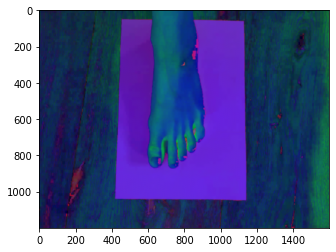

In [48]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg)

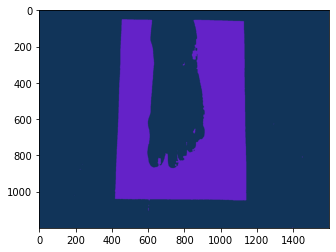

In [49]:
clusteredImg = kMeans_cluster(preprocessedOimg)
plotImage(clusteredImg)

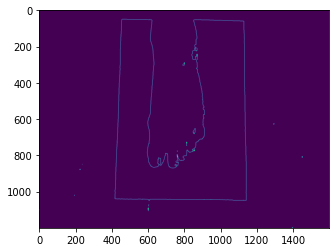

In [50]:
edgedImg = edgeDetection(clusteredImg)
plotImage(edgedImg)

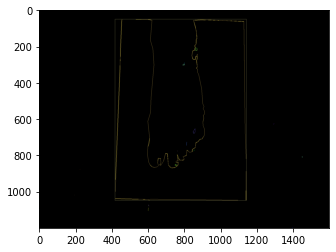

In [51]:
#getting paper bounding box

boundRect, contours, contours_poly, img = getBoundingBox(edgedImg)
pdraw = drawCnt(boundRect[1], contours, contours_poly, img)
plotImage(pdraw)


419 50 725 998


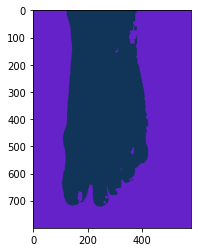

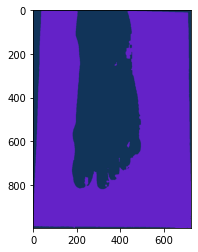

In [52]:
croppedImg, pcropedImg = cropOrig(boundRect[1], clusteredImg)
plotImage(croppedImg)
plotImage(pcropedImg)


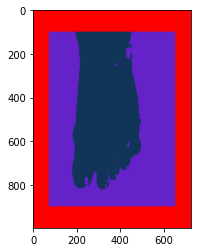

In [53]:
newImg = overlayImage(croppedImg, pcropedImg)
plotImage(newImg)

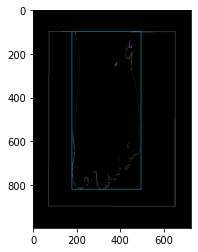

In [54]:

fedged = edgeDetection(newImg)
fboundRect, fcnt, fcntpoly, fimg = getBoundingBox(fedged)
fdraw = drawCnt(fboundRect[2], fcnt, fcntpoly, fimg)
plotImage(fdraw)

In [55]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh:
    ofs = (opw/pw)*fw
  else :
    ofs = (oph/ph)*fh



  return ofs


In [56]:
print("feet size: ", calcFeetSize(pcropedImg, fboundRect))

feet size:  244.32565130260522
